In [1]:
x=1

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import decoupler as dc

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
sc.set_figure_params(vector_friendly=True, figsize=(4,4))

In [4]:
#adata = sc.read('../../pipeline/data/multigrate_mil/pbmc_mtg_final1/old_0b64090fba_adata_both.h5ad')
adata = sc.read('../../../pipeline/data/multigrate_mil/pbmc_mtg_final1/c1d69bdf7d_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

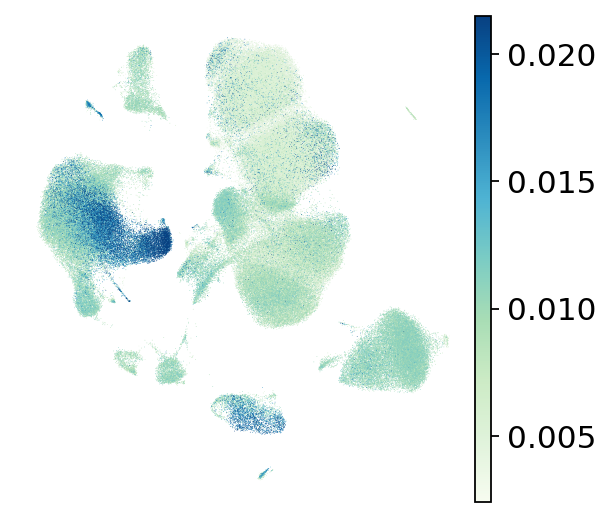

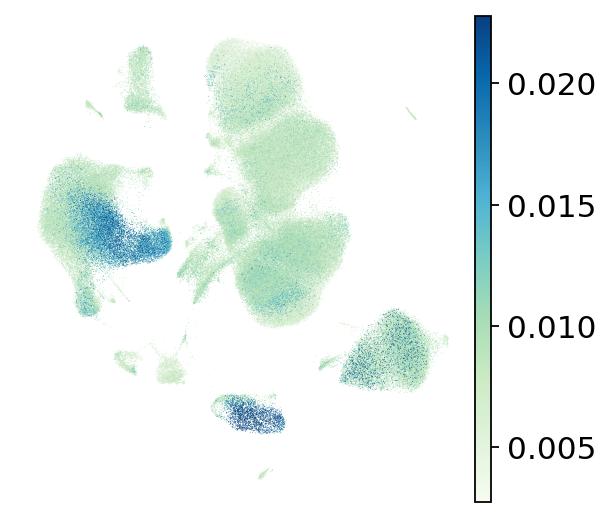

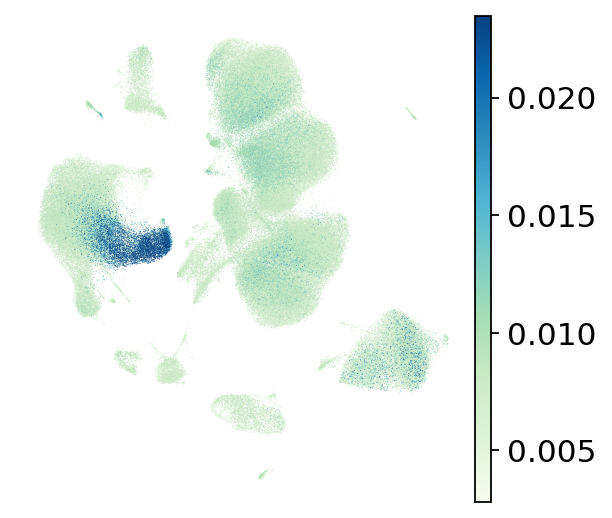

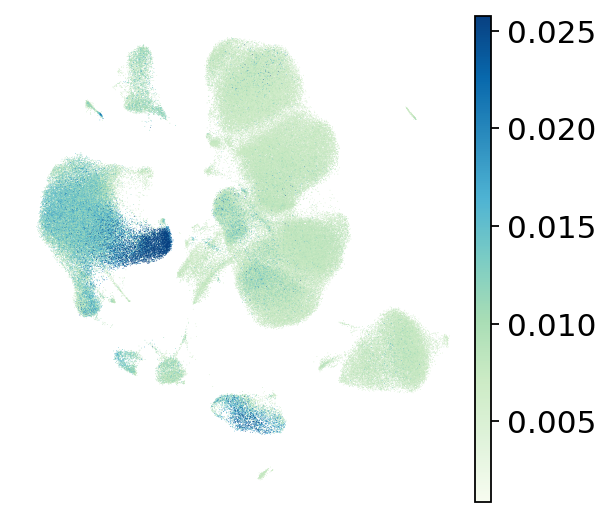

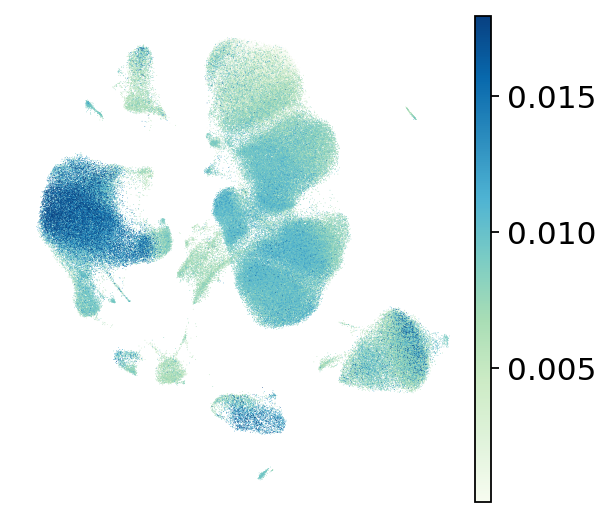

In [5]:
for i in range(5):
    sc.pl.umap(
        adata,
        color=[f'cell_attn_{i}'],
        frameon=False,
        ncols=1,
        #palette=colors,
        color_map="GnBu",
        title='',
        legend_loc=None,
        vmax='p99',
        save=f'_pbmc_cell_attn_{i}.svg'
)

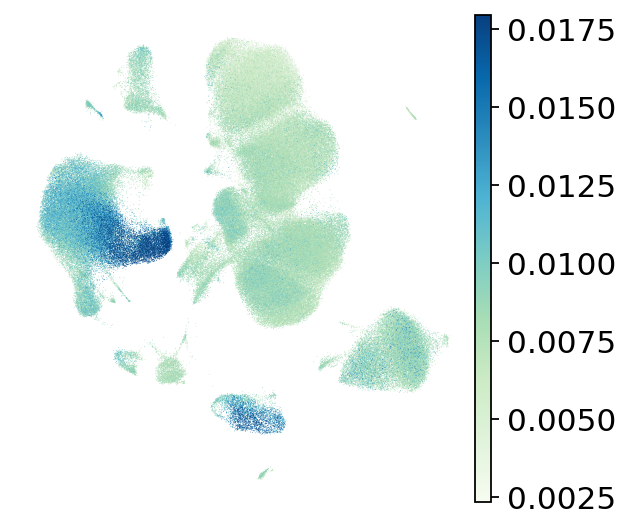

In [6]:
sc.pl.umap(
    adata,
    color=['cell_attn'],
    frameon=False,
    ncols=1,
    #palette=colors,
    color_map="GnBu",
    title='',
    legend_loc=None,
    vmax='p99',
    save='_pbmc_cell_attn.svg'
)

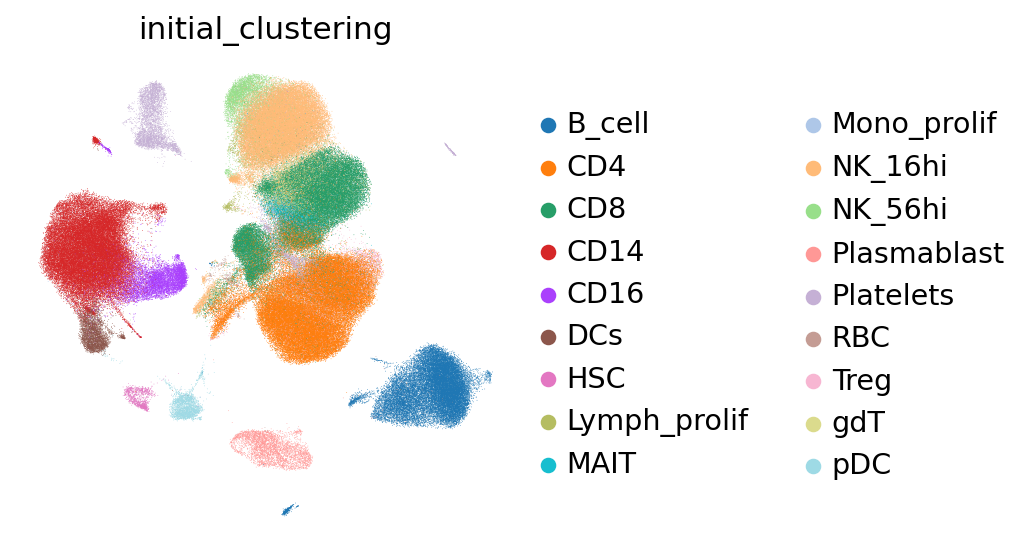

In [7]:
sc.pl.umap(
    adata,
    color=['initial_clustering'],
    ncols=1,
    frameon=False, 
    save='_pbmc_celltypes.svg'
)

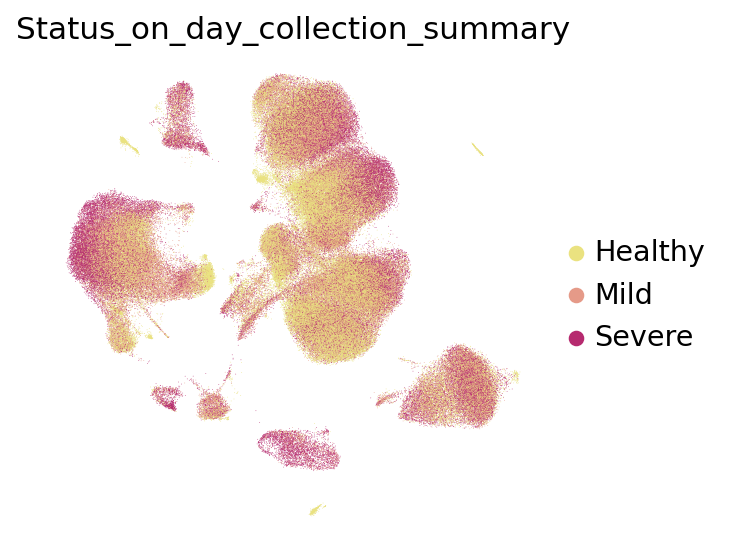

In [8]:
sc.pl.umap(
    adata,
    color=['Status_on_day_collection_summary'],
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    ncols=1,
    frameon=False,
    save='_pbmc_cond.svg'
)

In [9]:
dfs = []
for cond in np.unique(adata.obs['Status_on_day_collection_summary']):
    adata_tmp = adata[adata.obs['Status_on_day_collection_summary'] == cond].copy()
    threshold_idx = int(len(adata_tmp) * 0.9)
    threshold_value = sorted(adata_tmp.obs['cell_attn'])[threshold_idx]
    adata_tmp.obs['group'] = 'all cells'
    adata_tmp.obs.loc[adata_tmp.obs['cell_attn'] >= threshold_value, 'group'] = 'top 10% cells'
    adata.obs[f'top_cells_{cond}'] = False
    adata.obs.loc[adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs_names, f'top_cells_{cond}'] = True
    adata.obs[f'top_cells_{cond}'] = adata.obs[f'top_cells_{cond}'].astype('category')
    dfs.append(adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs[['initial_clustering', 'Status_on_day_collection_summary']])

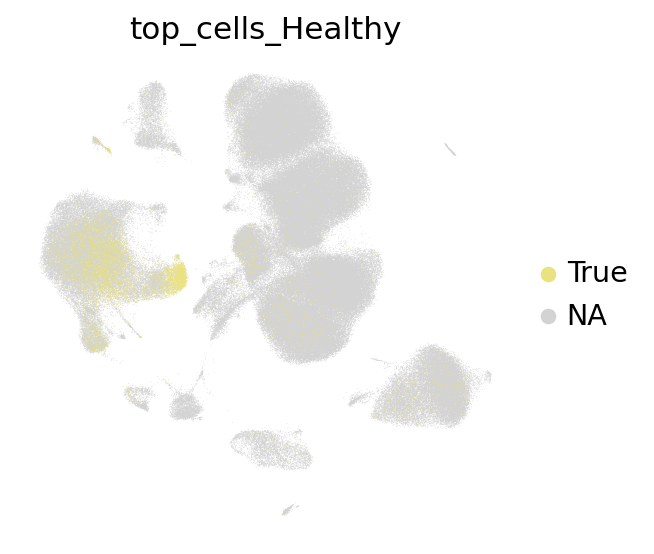

In [10]:
sc.pl.umap(
    adata,
    color=[f'top_cells_Healthy'],
    groups=[True],
    palette=['#EAE280'],
    frameon=False,
    save='_pbmc_top_healthy.svg'
)

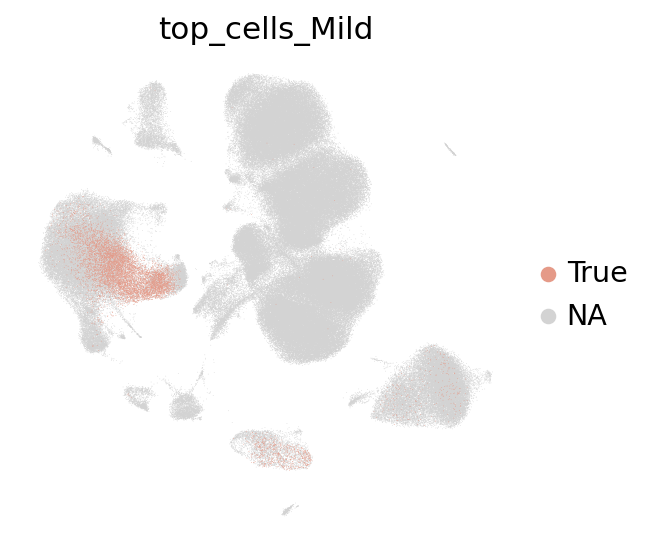

In [11]:
sc.pl.umap(adata, color=[f'top_cells_Mild'], groups=[True], palette=['#E59A88'], frameon=False, 
           save='_pbmc_top_mild.svg'
          )

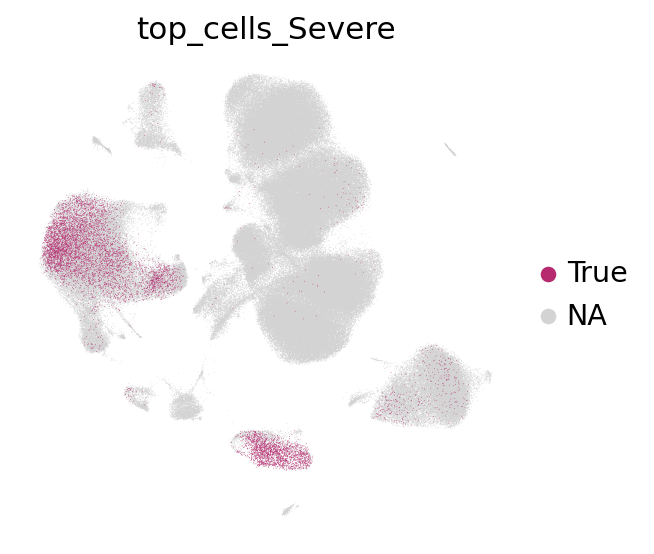

In [12]:
sc.pl.umap(adata, color=[f'top_cells_Severe'], groups=[True], palette=['#B62A6F'], frameon=False, 
           save='_pbmc_top_severe.svg'
          )

In [13]:
ct_df = adata.obs[['Status_on_day_collection_summary', 'initial_clustering']]
ct_df_group = ct_df.groupby('Status_on_day_collection_summary').value_counts(normalize=True).mul(100)
ct_df_group = ct_df_group.unstack().reindex(['Healthy', 'Mild', 'Severe']).T

In [14]:
ct_df_group['Mild - Healthy'] = (ct_df_group['Mild'] - ct_df_group['Healthy']) / ct_df_group['Healthy']
ct_df_group['Severe - Healthy'] = (ct_df_group['Severe'] - ct_df_group['Healthy']) / ct_df_group['Healthy']
ct_df_group['Severe - Mild'] = (ct_df_group['Severe'] - ct_df_group['Mild']) / ct_df_group['Healthy']
ct_df_group

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
B_cell,7.798926,10.613397,11.691050,0.360879,0.499059,0.138180
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
CD14,10.626655,18.917111,17.498243,0.780157,0.646637,-0.133520
CD16,3.571760,4.007579,1.963841,0.122018,-0.450176,-0.572194
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
HSC,0.148394,0.242733,1.020891,0.635737,5.879597,5.243860
Lymph_prolif,0.290605,1.330080,1.308375,3.576939,3.502250,-0.074689
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534


In [15]:
adata.obs['initial_clustering'].value_counts()

CD4             63893
CD8             41244
CD14            39282
NK_16hi         36366
B_cell          25288
CD16             8239
Platelets        6600
gdT              6117
Treg             5476
NK_56hi          5296
Plasmablast      3910
DCs              3807
MAIT             3386
pDC              2660
Lymph_prolif     2380
HSC              1139
RBC               793
Mono_prolif       175
Name: initial_clustering, dtype: int64

In [16]:
ct_df_group = ct_df_group.drop(['RBC', 'Mono_prolif'])

In [17]:
ct_df_group

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
B_cell,7.798926,10.613397,11.691050,0.360879,0.499059,0.138180
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
CD14,10.626655,18.917111,17.498243,0.780157,0.646637,-0.133520
CD16,3.571760,4.007579,1.963841,0.122018,-0.450176,-0.572194
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
HSC,0.148394,0.242733,1.020891,0.635737,5.879597,5.243860
Lymph_prolif,0.290605,1.330080,1.308375,3.576939,3.502250,-0.074689
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534


In [18]:
ct_df_group.sort_values('Mild - Healthy')

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534
gdT,3.701605,2.147448,1.010669,-0.419860,-0.726965,-0.307104
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
Platelets,2.210451,1.815547,3.819076,-0.178653,0.727736,0.906389
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
Treg,2.411402,2.128872,1.810516,-0.117164,-0.249185,-0.132021
NK_56hi,2.289801,2.184601,1.673801,-0.045943,-0.269019,-0.223076
NK_16hi,13.025691,12.726169,17.185204,-0.022995,0.319332,0.342326


In [19]:
ct_df_group.sort_values('Severe - Healthy')

Status_on_day_collection_summary,Healthy,Mild,Severe,Mild - Healthy,Severe - Healthy,Severe - Mild
initial_clustering,,,,,,
MAIT,2.075454,1.202521,0.512362,-0.420598,-0.753133,-0.332534
gdT,3.701605,2.147448,1.010669,-0.419860,-0.726965,-0.307104
DCs,2.179536,1.390764,0.727017,-0.361899,-0.666435,-0.304536
CD16,3.571760,4.007579,1.963841,0.122018,-0.450176,-0.572194
CD4,29.130556,24.407099,20.337316,-0.162148,-0.301856,-0.139708
NK_56hi,2.289801,2.184601,1.673801,-0.045943,-0.269019,-0.223076
CD8,19.369532,14.057488,14.178752,-0.274247,-0.267987,0.006261
Treg,2.411402,2.128872,1.810516,-0.117164,-0.249185,-0.132021
NK_16hi,13.025691,12.726169,17.185204,-0.022995,0.319332,0.342326


In [20]:
df = ct_df_group.loc[['Plasmablast', 'HSC', 'Lymph_prolif', 'pDC', 'Platelets']]

In [21]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))

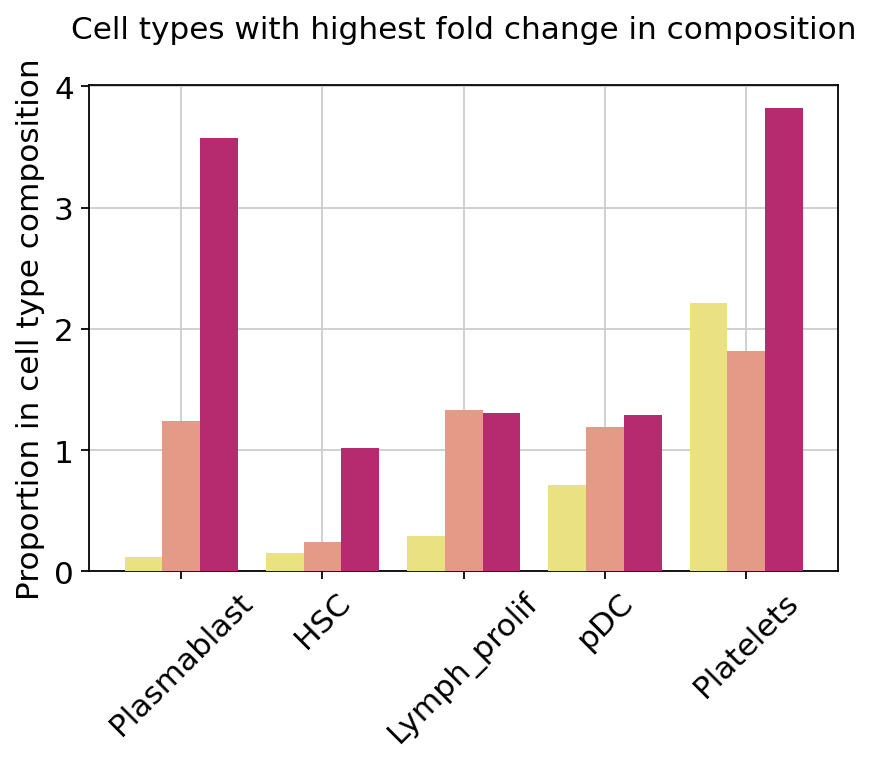

In [22]:
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
df[['Healthy', 'Mild', 'Severe']].plot.bar(color=['#EAE280', '#E59A88', '#B62A6F'], rot=45, legend=False, ax=ax, zorder=3, width=0.8)
plt.title('Cell types with highest fold change in composition\n')
plt.xlabel('')
plt.ylabel('Proportion in cell type composition')
plt.savefig('figures/bar_pbmc_proportions.svg', bbox_inches='tight')

In [23]:
df = pd.read_csv('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/multimil_reproducibility/pipeline/data/reports/best.tsv', sep='\t', index_col=None)
task = 'pbmc_mtg_final1'

In [24]:
runs = {}
yerr = {}
df_task = df[df['task'] == task]
for method in np.unique(df_task['method']):
    runs[method] = eval(df_task.loc[df_task['method'] == method, 'accuracies'].values[0])
    yerr[method] = np.array(runs[method]).std()

df_tmp = df_task[['method', 'accuracy']]
df_tmp.index = df_tmp['method']
df_tmp = df_tmp[['accuracy']].sort_values('accuracy', ascending=False)
df_tmp = df_tmp.T

yerr_sorted = [yerr[method] for method in df_tmp.columns]

In [25]:
df_tmp.columns

Index(['multigrate_mil_reg', 'multigrate_mil', 'ct_pb_rf', 'freq_rf',
       'ct_pb_nn', 'pb_nn', 'ct_pb_mr', 'pb_rf', 'freq_nn', 'gex_rf',
       'freq_mr', 'gex_nn'],
      dtype='object', name='method')

In [26]:
df_tmp = df_tmp[['multigrate_mil_reg', 'multigrate_mil',  
                 #
                 'ct_pb_rf', 
                 'ct_pb_nn', 
                 'ct_pb_mr',
                 #
                 'freq_rf', 'freq_nn', 'freq_mr',
                 #
                 'pb_nn', 'pb_rf', 
                 #
                 'gex_rf', 'gex_nn']]

In [27]:
df_tmp.columns

Index(['multigrate_mil_reg', 'multigrate_mil', 'ct_pb_rf', 'ct_pb_nn',
       'ct_pb_mr', 'freq_rf', 'freq_nn', 'freq_mr', 'pb_nn', 'pb_rf', 'gex_rf',
       'gex_nn'],
      dtype='object', name='method')

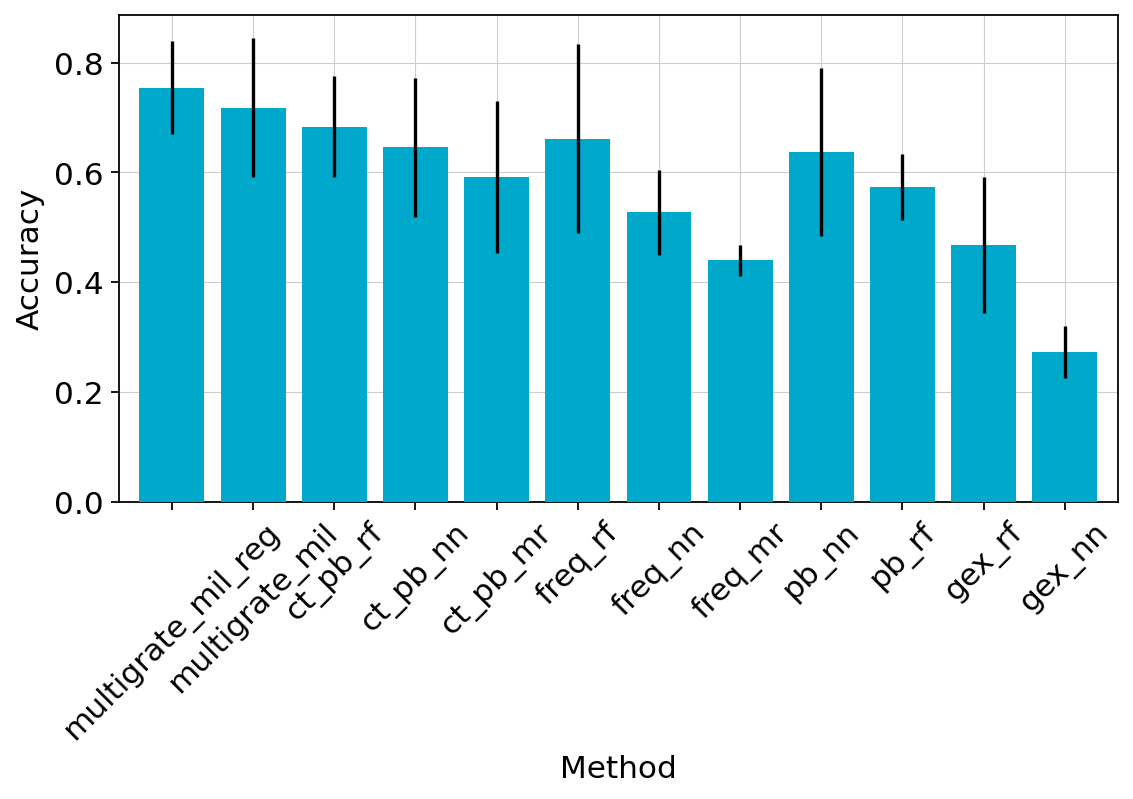

In [28]:
ax = df_tmp.T.plot(kind='bar', zorder=3, figsize=(8, 4), color=["#00a8cc"], rot=45, yerr=yerr_sorted, width=0.8)
ax.get_legend().remove()
ax.grid(zorder=0, linewidth=0.5)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('')
plt.savefig('figures/pbmc_accuracy.svg', bbox_inches='tight')

### patient repr

In [29]:
adata.obs

,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,full_clustering,initial_clustering,Resample,Collection_Day,...,_scvi_batch,cell_attn_0,cell_attn_1,cell_attn_2,cell_attn_3,cell_attn_4,cell_attn,top_cells_Healthy,top_cells_Mild,top_cells_Severe
covid_index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACCACGA-newcastle65,newcastle65,1351,1351,4278.0,178.0,4.160823,CD4.Naive,CD4,Initial,D0,...,0,0.005285,0.007994,0.009840,0.006811,0.008198,0.007626,False,False,False
AAACCTGAGATGTCGG-newcastle65,newcastle65,1921,1921,4740.0,127.0,2.679325,NK_16hi,NK_16hi,Initial,D0,...,0,0.005317,0.004554,0.006208,0.005122,0.007075,0.005655,False,False,False
AAACCTGAGGCGATAC-newcastle65,newcastle65,1056,1056,2875.0,198.0,6.886957,CD4.Naive,Treg,Initial,D0,...,0,0.004986,0.008441,0.007140,0.005789,0.009767,0.007225,False,False,False
AAACCTGAGTACACCT-newcastle65,newcastle65,2140,2140,5260.0,316.0,6.007605,NK_16hi,NK_16hi,Initial,D0,...,0,0.005446,0.004498,0.010905,0.006797,0.002195,0.005968,False,False,False
AAACCTGAGTGAATTG-newcastle65,newcastle65,1620,1620,4043.0,232.0,5.738313,CD8.EM,CD4,Initial,D0,...,0,0.006557,0.008511,0.009079,0.006861,0.009090,0.008019,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,BGCV15_CV0176,1631,1631,5325.0,184.0,3.455399,CD4.CM,CD4,Resample,D28,...,0,0.005828,0.014170,0.008552,0.006730,0.013829,0.009822,False,False,False
BGCV15_TTTGGTTTCAAGATCC-1,BGCV15_CV0944,2503,2503,6681.0,264.0,3.951504,NK_16hi,NK_16hi,Initial,D0,...,0,0.005365,0.006597,0.008336,0.008000,0.003261,0.006312,False,False,False
BGCV15_TTTGTCAAGGCGATAC-1,BGCV15_CV0176,2401,2401,8633.0,490.0,5.675895,CD4.CM,CD4,Resample,D28,...,0,0.007489,0.007248,0.007763,0.007571,0.013193,0.008653,False,False,False


In [30]:
tmp = adata

In [31]:
for i in range(tmp.X.shape[1]):
    tmp.obs[f'latent{i}'] = tmp.X[:, i].copy()
    tmp.obs[f'latent{i}_weighted'] = tmp.obs[f'latent{i}'] * tmp.obs['cell_attn']
tmp.obs[['latent0', 'latent0_weighted', 'cell_attn']]

,latent0,latent0_weighted,cell_attn
covid_index,,,
AAACCTGAGACCACGA-newcastle65,-0.170344,-0.001299,0.007626
AAACCTGAGATGTCGG-newcastle65,-1.007411,-0.005697,0.005655
AAACCTGAGGCGATAC-newcastle65,-0.251497,-0.001817,0.007225
AAACCTGAGTACACCT-newcastle65,-0.701973,-0.004190,0.005968
AAACCTGAGTGAATTG-newcastle65,-0.109289,-0.000876,0.008019
...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,0.413836,0.004065,0.009822
BGCV15_TTTGGTTTCAAGATCC-1,-0.254439,-0.001606,0.006312
BGCV15_TTTGTCAAGGCGATAC-1,-0.605825,-0.005242,0.008653


In [32]:
df = tmp.obs[[f'latent{i}' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0,latent1,latent2,latent3,latent4,latent5,latent6,latent7,latent8,latent9,...,latent12,latent13,latent14,latent15,latent16,latent17,latent18,latent19,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,0.344548,-0.150528,0.306088,-0.187310,0.218147,-0.077847,0.230981,-0.208586,-0.254200,0.043318,...,0.047392,-0.403155,-0.187793,-0.164077,-0.282662,0.319426,-0.171868,-0.065580,Severe,Sanger
AP4,0.165106,-0.236559,0.614609,-0.148086,-0.038765,-0.132805,0.151039,-0.324218,-0.330311,-0.025014,...,-0.030480,-0.076111,-0.179940,-0.233890,-0.197369,0.096934,-0.378309,-0.326807,Mild,Sanger
AP5,0.413475,-0.663631,-0.038010,-0.501842,-0.212037,-0.038159,-0.037974,-0.089472,-0.399102,-0.011391,...,-0.117136,-0.107880,-0.293442,-0.190262,0.079365,-0.133489,0.218204,-0.356163,Severe,Sanger


In [33]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [34]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [35]:
loo = LeaveOneOut()

In [36]:
mean_train_accuracies = {}
mean_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    mean_train_accuracies[k] = train_accuracies
    mean_test_accuracies[k] = test_accuracies

In [37]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(mean_train_accuracies[k])))
    print(np.mean(np.array(mean_test_accuracies[k])))

k = 3:
0.7976190476190476
0.6122448979591837
k = 5:
0.7351190476190476
0.6326530612244898
k = 7:
0.6968537414965985
0.6530612244897959
k = 9:
0.71343537414966
0.6122448979591837


In [38]:
sc.pp.neighbors(pb)

In [39]:
sc.tl.umap(pb)

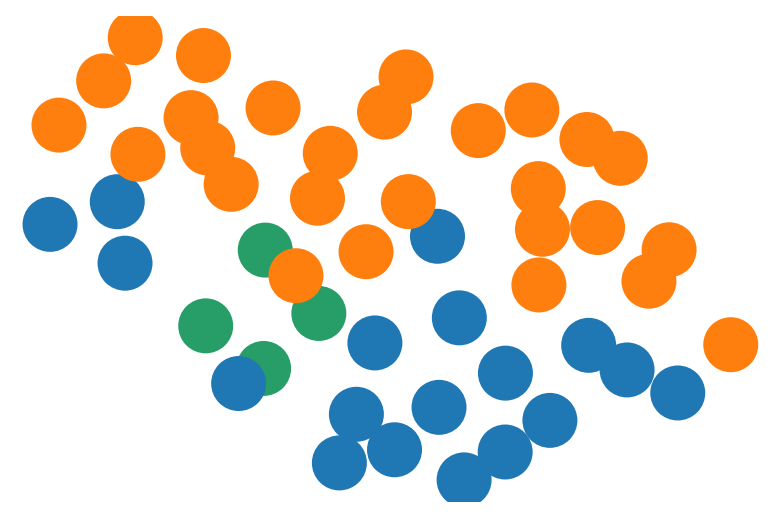

In [40]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_site.svg'
)

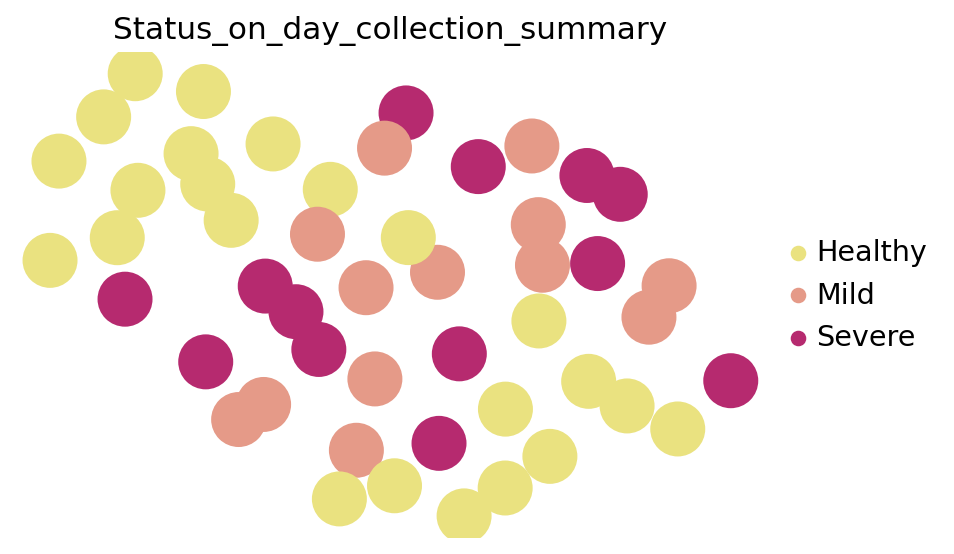

In [41]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_mean.svg'
)

In [42]:
df = tmp.obs[[f'latent{i}_weighted' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('sum')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0_weighted,latent1_weighted,latent2_weighted,latent3_weighted,latent4_weighted,latent5_weighted,latent6_weighted,latent7_weighted,latent8_weighted,latent9_weighted,...,latent12_weighted,latent13_weighted,latent14_weighted,latent15_weighted,latent16_weighted,latent17_weighted,latent18_weighted,latent19_weighted,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,11.161864,-3.902976,6.912970,-5.424129,9.668971,-5.598835,7.630893,-6.024137,-7.817546,1.570453,...,-0.833800,-13.826769,-5.880225,-4.888505,-9.130725,11.221870,-4.211534,4.929401,Severe,Sanger
AP4,10.100186,-13.355039,32.504810,-6.779468,-0.928060,-10.329085,7.730351,-19.617682,-18.317621,-1.724912,...,-5.836152,-3.237794,-8.675142,-12.965524,-13.460234,5.974086,-20.728745,-14.040131,Mild,Sanger
AP5,29.330181,-43.231285,-4.885829,-31.564604,-11.940878,-7.825343,-4.732965,-5.325182,-26.183567,-1.363706,...,-15.144775,-13.800699,-20.073515,-10.812865,3.985918,-9.750724,21.965342,-14.449382,Severe,Sanger


In [43]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [44]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [45]:
loo = LeaveOneOut()

In [46]:
attn_train_accuracies = {}
attn_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    attn_train_accuracies[k] = train_accuracies
    attn_test_accuracies[k] = test_accuracies

In [47]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(attn_train_accuracies[k])))
    print(np.mean(np.array(attn_test_accuracies[k])))

k = 3:
0.7568027210884354
0.6326530612244898
k = 5:
0.7185374149659864
0.6938775510204082
k = 7:
0.7363945578231293
0.6530612244897959
k = 9:
0.6985544217687074
0.6530612244897959


In [48]:
sc.pp.neighbors(pb)

In [49]:
sc.tl.umap(pb)

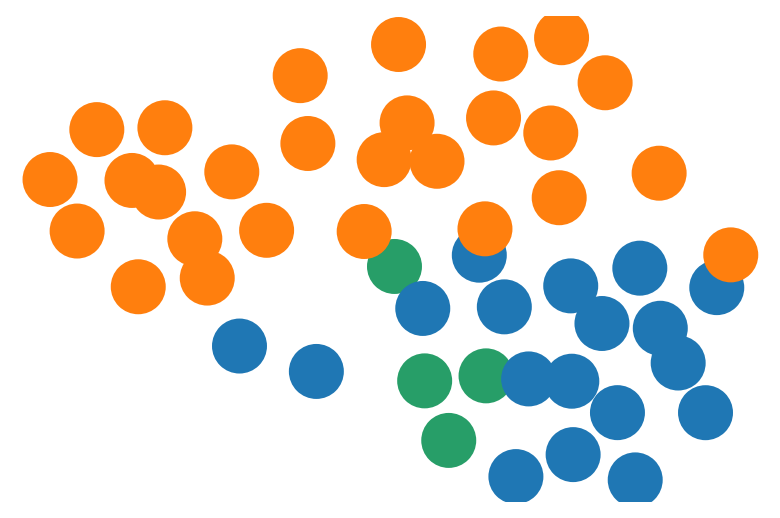

In [50]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_weighted_site.svg'
)

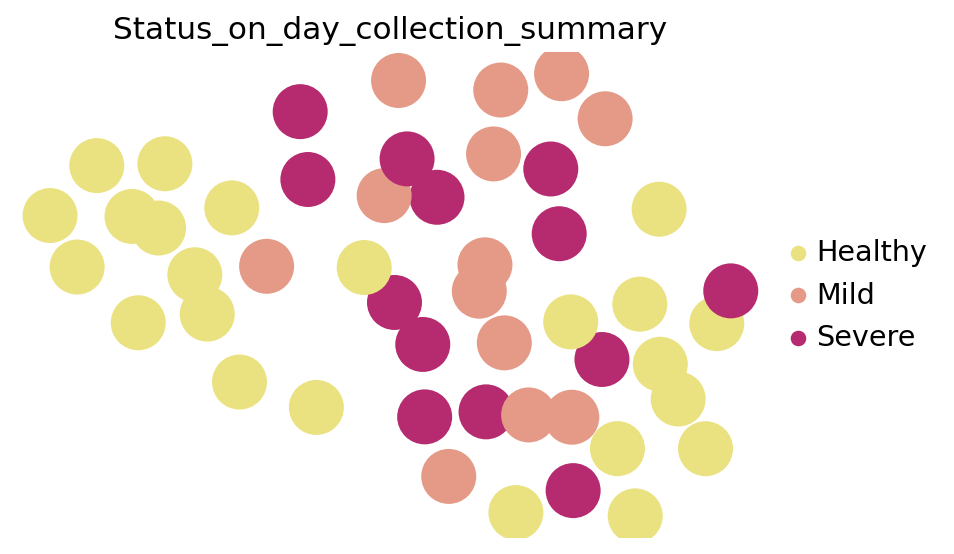

In [51]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_attn_weighted.svg'
)

In [52]:
df1 = pd.DataFrame(attn_test_accuracies)
df2 = pd.DataFrame(mean_test_accuracies)

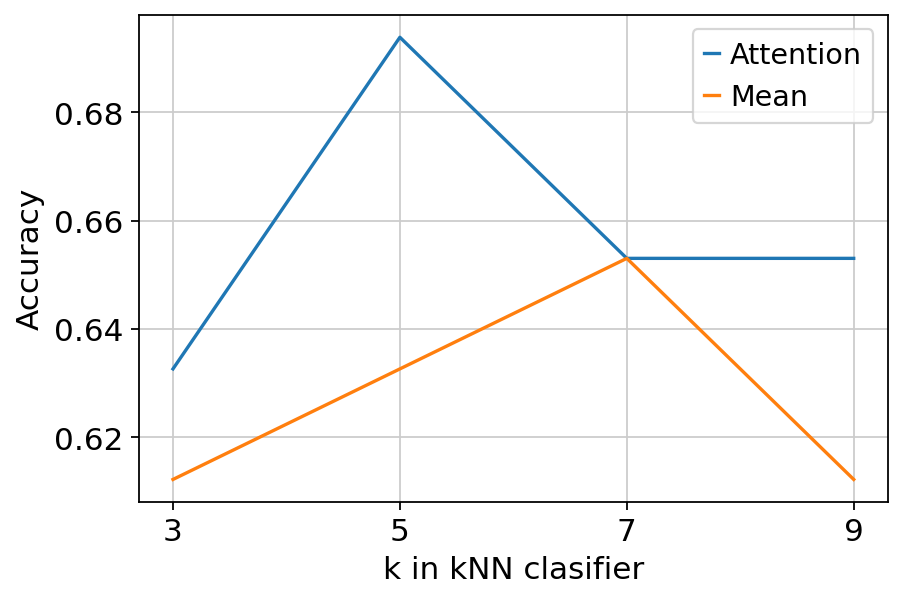

In [53]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
plt.plot(df1.mean().index.astype(str).values, df1.mean().values, label='Attention')
plt.plot(df2.mean().index.astype(str).values, df2.mean().values, label='Mean')
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('figures/mil_knn_classifier.svg', bbox_inches='tight')

In [54]:
adata_top = adata[(adata.obs['top_cells_Healthy'] == True) | (adata.obs['top_cells_Mild'] == True) | (adata.obs['top_cells_Severe'] == True)].copy()
adata_top

AnnData object with n_obs × n_vars = 25606 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_Healthy', 'top_cells_Mild', 'top_cells_Severe', 'latent0', 'latent0_weighted', 'latent1', 'latent1_weighted', 'latent2', 'latent2_weighted', 'latent3', 'latent3_weighted', 'latent4', 'latent4_weighted', 'latent5', 'latent5_weighted', 'latent6', 'latent6_weighted', 'latent7', 'latent7_weighted', 'latent8', 'latent8_weighted', 'latent9', 'latent9_weighted', 'latent10',

In [55]:
tmp_top = adata_top

In [56]:
for i in range(adata_top.X.shape[1]):
    tmp_top.obs[f'latent{i}'] = tmp_top.X[:, i].copy()

In [57]:
df = tmp_top.obs[[f'latent{i}' for i in range(tmp_top.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
df = df.join(tmp_top.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0,latent1,latent2,latent3,latent4,latent5,latent6,latent7,latent8,latent9,...,latent12,latent13,latent14,latent15,latent16,latent17,latent18,latent19,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,-0.407651,0.232034,-0.733186,-0.073510,0.782935,-0.783689,-0.048376,-0.049412,0.036656,-0.024586,...,-0.253325,-0.220748,0.173284,0.092479,0.427244,0.021672,0.360362,1.839478,Severe,Sanger
AP4,-0.464362,0.011502,-0.321637,0.164500,0.600626,-0.660129,-0.481704,-0.702354,-0.004245,-0.171565,...,-0.488669,-0.196341,0.284359,0.065156,0.333006,-0.393262,0.220559,1.316798,Mild,Sanger
AP5,0.122316,-0.403591,-0.550018,-0.124081,0.242874,-0.577509,-0.445187,-0.209010,-0.182782,-0.088376,...,-0.587124,-0.953554,-0.634814,-0.152417,0.193586,-0.490486,1.431121,1.087597,Severe,Sanger


In [58]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [59]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [60]:
loo = LeaveOneOut()

In [61]:
top_train_accuracies = {}
top_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    top_train_accuracies[k] = train_accuracies
    top_test_accuracies[k] = test_accuracies

In [62]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(top_train_accuracies[k])))
    print(np.mean(np.array(top_test_accuracies[k])))

k = 3:
0.858843537414966
0.8163265306122449
k = 5:
0.8715986394557822
0.7346938775510204
k = 7:
0.8329081632653061
0.7142857142857143
k = 9:
0.7414965986394558
0.6938775510204082


In [63]:
sc.pp.neighbors(pb)

In [64]:
sc.tl.umap(pb)

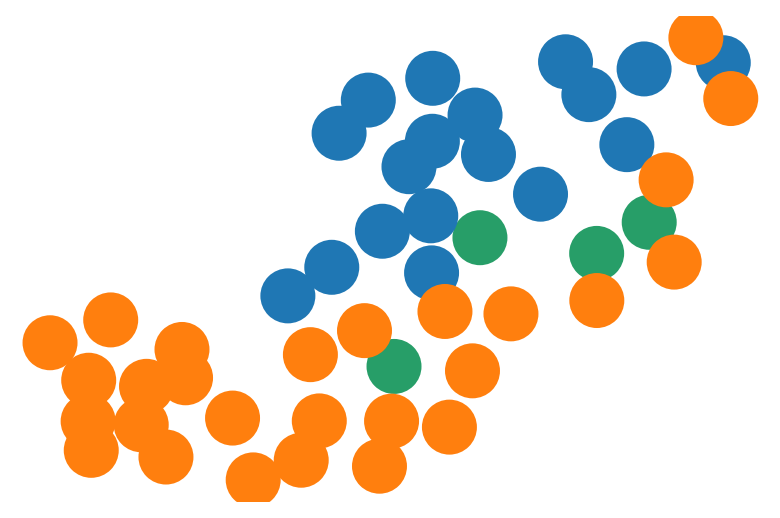

In [65]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_site.svg'
)

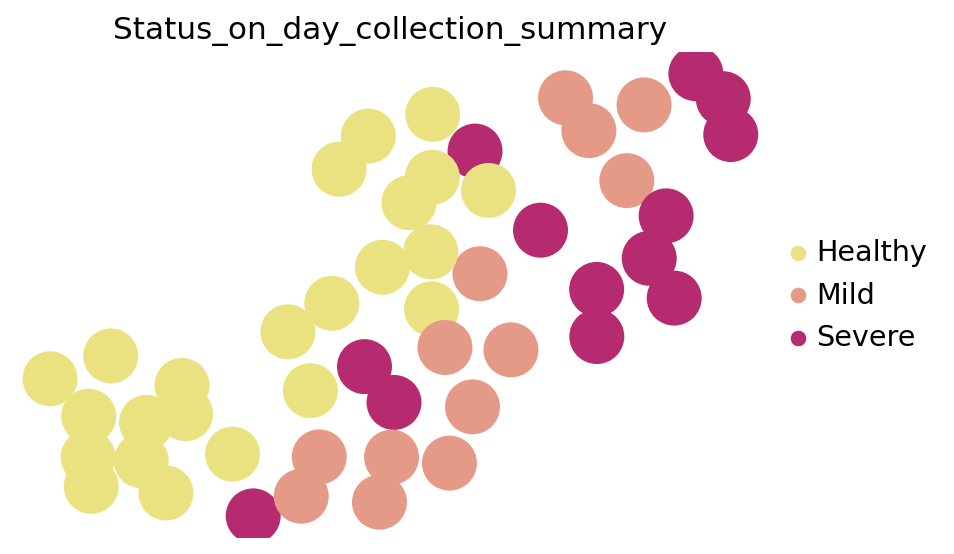

In [66]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_top10perc.svg'
)

In [67]:
df3 = pd.DataFrame(top_test_accuracies)

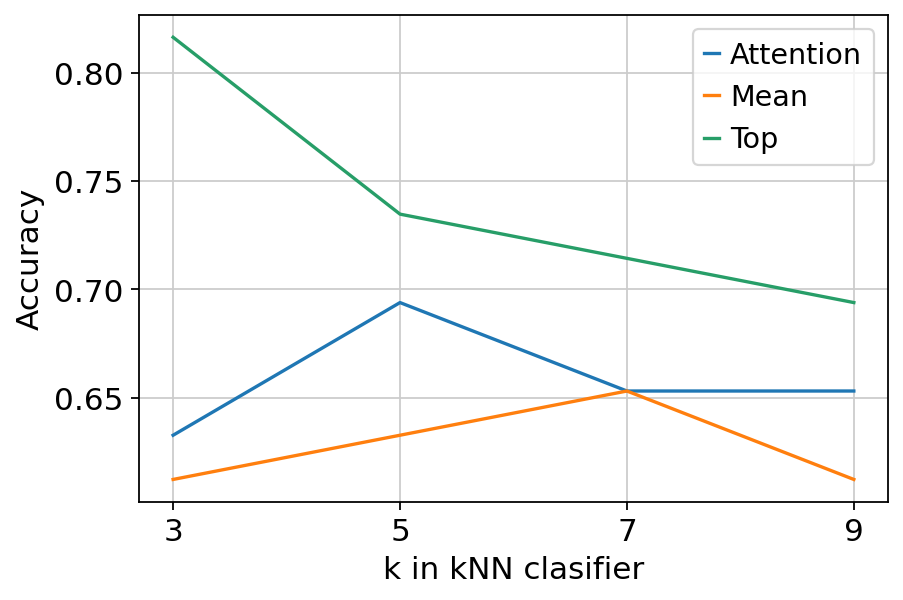

In [68]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
plt.plot(df1.mean().index.astype(str).values, df1.mean().values, label='Attention')
plt.plot(df2.mean().index.astype(str).values, df2.mean().values, label='Mean')
plt.plot(df3.mean().index.astype(str).values, df3.mean().values, label='Top')
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mil_knn_classifier.svg', bbox_inches='tight')

In [69]:
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_Healthy', 'top_cells_Mild', 'top_cells_Severe', 'latent0', 'latent0_weighted', 'latent1', 'latent1_weighted', 'latent2', 'latent2_weighted', 'latent3', 'latent3_weighted', 'latent4', 'latent4_weighted', 'latent5', 'latent5_weighted', 'latent6', 'latent6_weighted', 'latent7', 'latent7_weighted', 'latent8', 'latent8_weighted', 'latent9', 'latent9_weighted', 'latent10'

In [70]:
dfs = {}
for top_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    threshold_idx = int(len(adata) * top_percentage)
    threshold_value = sorted(adata.obs['cell_attn'])[threshold_idx]
    adata_top = adata[adata.obs['cell_attn'] >= threshold_value].copy()
    for i in range(adata_top.X.shape[1]):
        adata_top.obs[f'latent{i}'] = adata_top.X[:, i].copy()
    df = adata_top.obs[[f'latent{i}' for i in range(adata_top.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
    df = df.join(adata_top.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
    pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
    pb.obs = df[['Status_on_day_collection_summary', 'Site']]
    X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
    y = df[['Status_on_day_collection_summary']].values.ravel()
    loo = LeaveOneOut()
    top_train_accuracies = {}
    top_test_accuracies = {}
    for k in [3, 5, 7, 9]:
        train_accuracies = []
        test_accuracies = []
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            knn = KNeighborsClassifier(n_neighbors = k)
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            knn.fit(X_train, y_train)
            y_train_predict = knn.predict(X_train)
            y_test_predict = knn.predict(X_test)
            train_accuracies.append(np.mean(y_train_predict == y_train))
            test_accuracies.append(np.mean(y_test_predict == y_test))
        # top_train_accuracies[k] = train_accuracies
        top_test_accuracies[k] = test_accuracies
    dfs[top_percentage] = pd.DataFrame(top_test_accuracies)

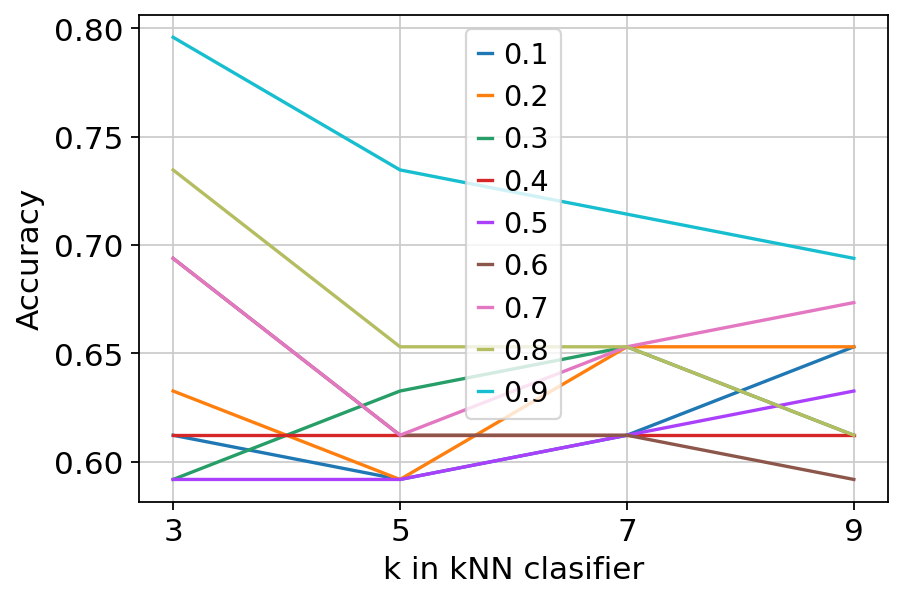

In [71]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
for top_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(dfs[top_percentage].mean().index.astype(str).values, dfs[top_percentage].mean().values, label=top_percentage)
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mil_knn_classifier_top.svg', bbox_inches='tight')